#Introduction( aka getting into the Physics behind the code)

Our data comes from the Transit Exoplanet Survey Satellite (TESS) which uses the $\textbf{...drumrolls...}$  Transit Method to determine extra solar planets. The basic idea is that its really hard to distinguish a distant planet from its *also distant* parent star.

However, when the planet transits/ crosses infront of its parent disk in our field of view, the observed flux drops(check the cool figure from Wikipedia.  And that *drop* is what we are going to probe the data for.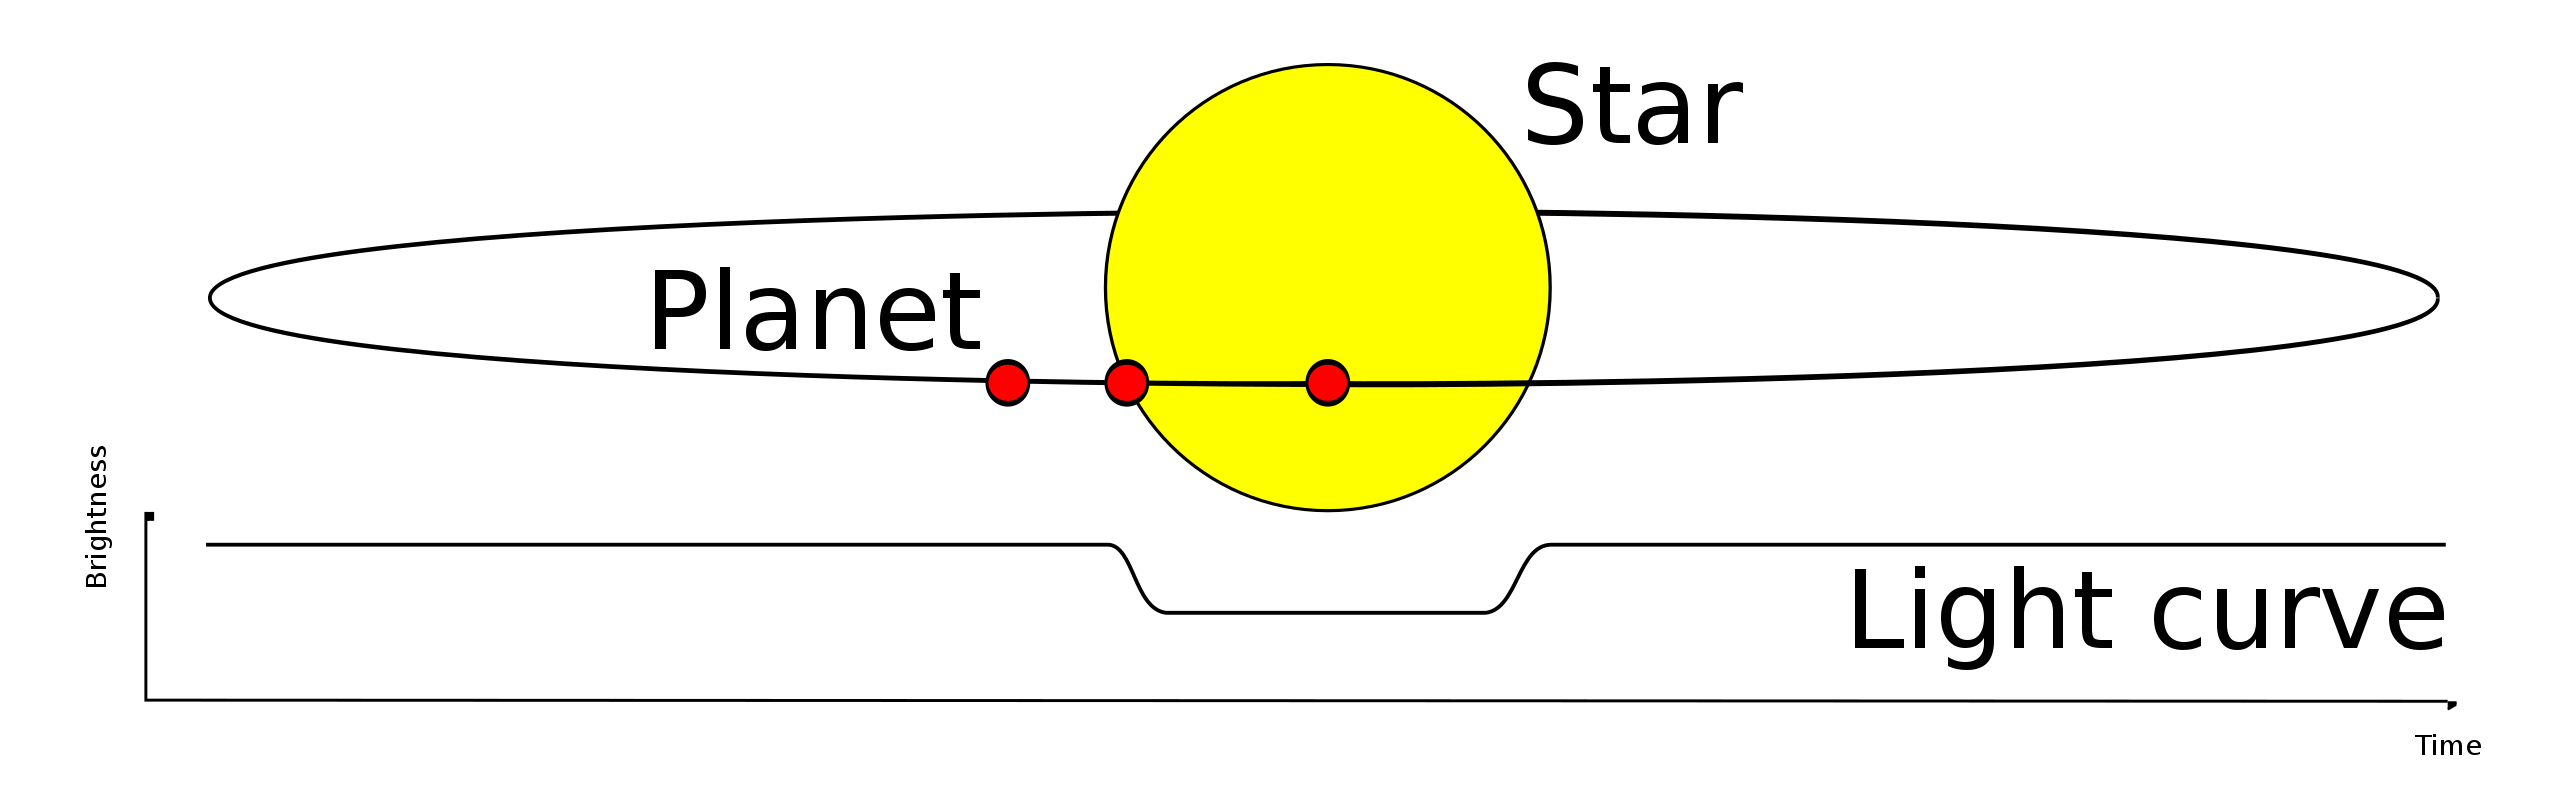



I will be using Python's Lightkurve Library, along with documentation, tutorials, and some papers that I have taken help from in this project.(Acknowledgements are at the end)


In [ ]:
#Only run if you dont have it installed
#pip install lightkurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.7/909.7 kB 39.6 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=d8ca5e6e89897bfac37a197e30450d793529d1bb1bbc3d7a2ca79bedc2c1955d
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50453 sha256=af9a630d64e8348d12073564a7f18370f79c3f9b94ceffba1fbd3a4574513b6b
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b55

#The Code

I will start by using the Kepler missions,which are already well analysed to test our simple approach and then I will use it on th TESS data. Lets buckle up and get into it!!

In [ ]:
#Importing the necessary library
from lightkurve import TessTargetPixelFile
import lightkurve as lk
import numpy as np

<Axes: title={'center': 'Target ID: 6922244, Cadence: 11957'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

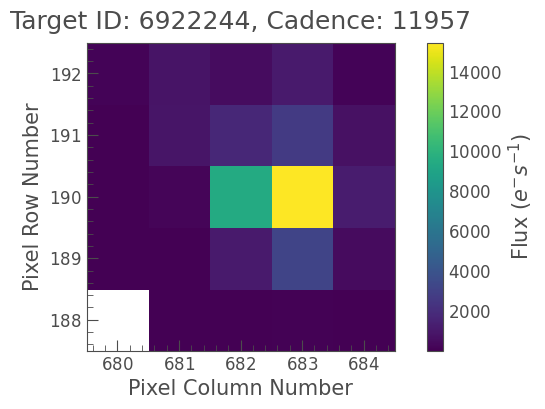

In [ ]:
#Probing data from the Kepler Mission. KIC 6922244 is Kepler 8b
search_result = lk.search_targetpixelfile("KIC 6922244", author="Kepler", cadence="long",quarter="4").download()

#One pixel Frame is being plotted here
search_result.plot(frame=41)

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

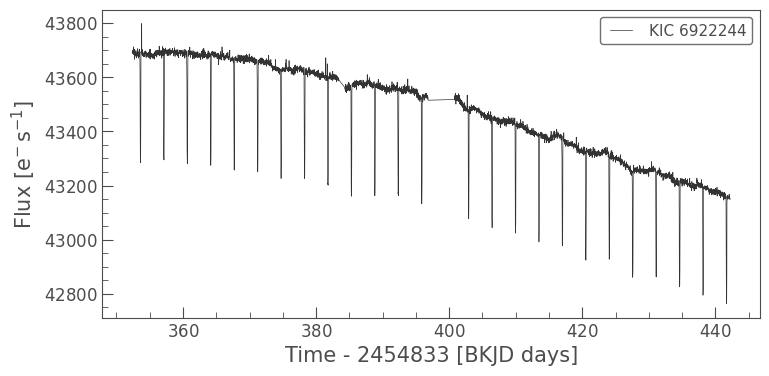

In [ ]:
# Now I am going to fit all the individual pixels to a light curve.
#The pipeline mask is designed by the TESS mission team to include pixels that are considered most relevant for the photometric analysis
lc=search_result.to_lightcurve(aperture_mask=search_result.pipeline_mask)
lc.time
lc.flux
lc.plot()

The Flux vs Time graph shows a sharp decrease periodically. However, we do not know the periodicity of this phenomenon. I will flatten the light curve, which will make the data look better by normalizing the flux. The curve is then spliced according to period and then stacked on to itself- this is done by the inbuilt fold function.

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

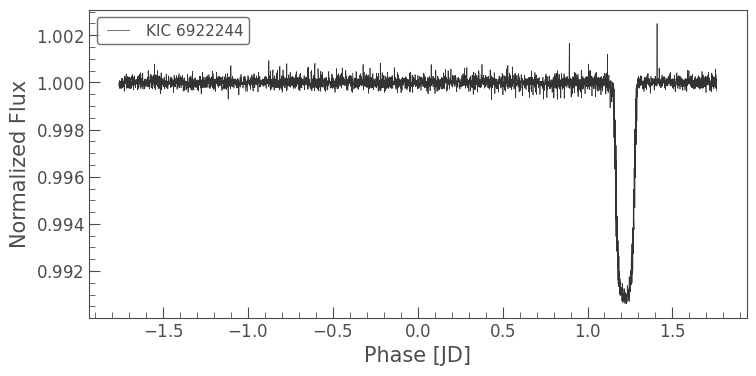

In [ ]:
#Flattening and Folding the curve.
folded_lc=lc.flatten().fold(period=3.523)
folded_lc.plot()


Woo hoo! The Shape is very similar to what we expect. Now all we need is a fit to the lightcurve that gave us a better value for the period of transit.


For this, We're going to do  a BLS periodogram analysis on a the given light curve, identify the period, transit time, and duration of the most significant signal, and then plot the folded light curve for visual inspection.

'The period of the planet is 3.522652265226523 d'

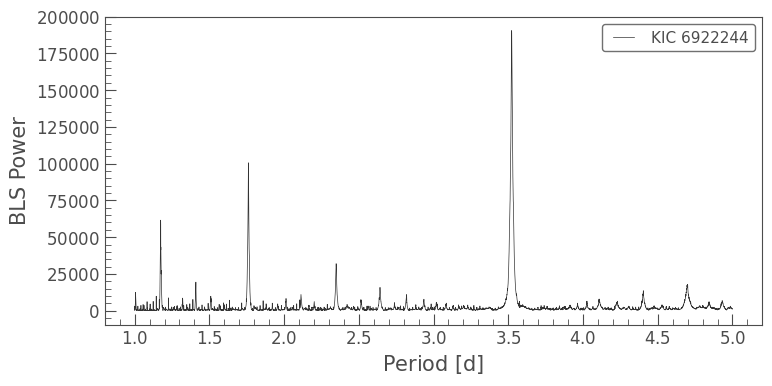

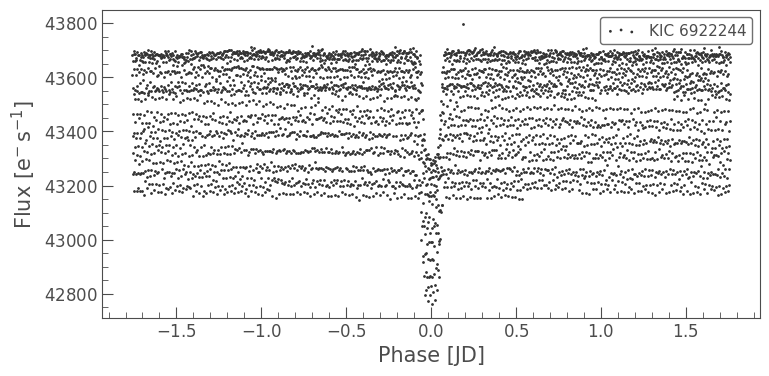

In [ ]:
period=np.linspace(1,5,10000)
bls=lc.to_periodogram(method='bls',period=period,frequency_factor=500)
bls.plot()

#Using the periodogram to find period, the time of the center of the transit, and the duration of the transit.
planet_x_period=bls.period_at_max_power
planet_x_t=bls.transit_time_at_max_power
planet_x_dur=bls.duration_at_max_power

#Fold the light curve then plot a scatter plot . Folding the light curve helps phase-align the transits for better visualization.
ax=lc.fold(period=planet_x_period,epoch_time=planet_x_t).scatter()
f'The period of the planet is {planet_x_period}'




Repeating the steps, but this time downloading TESS Data from the Barbara A. Mikulski Archive.

In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Function that downloads and unzips the data from a MAST url
def download_and_unzip(url,extract_to='.'):
  http_response=urlopen(url)
  zipfile=ZipFile(BytesIO(http_response.read()))
  zipfile.extractall(path=extract_to)

# change this up to probe for a different celestial object to see if it has a exoplanet.
product_group_id='62337089'
url = 'https://mast.stsci.edu/api/v0.1/Download/bundle.zip?previews=false&obsid=' + product_group_id
destination="/content/TESS/"

download_and_unzip(url,destination)


'The period of the planet is 4.007900790079008 d'

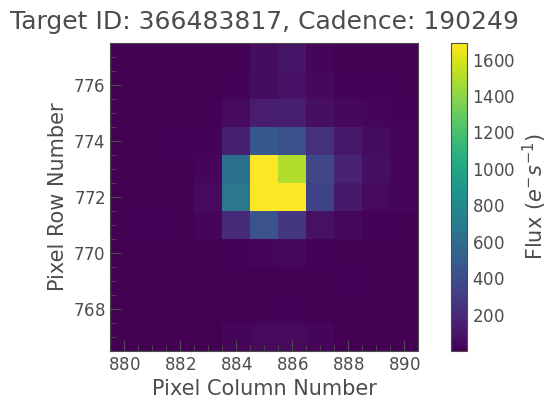

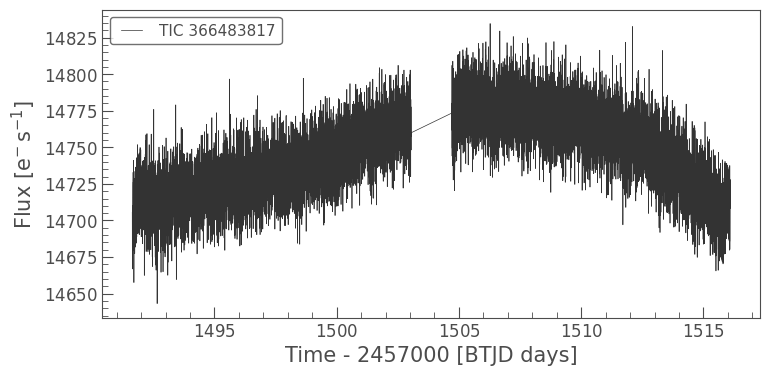

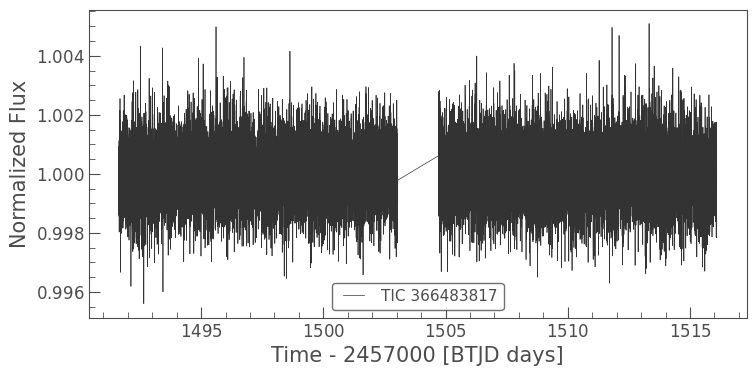

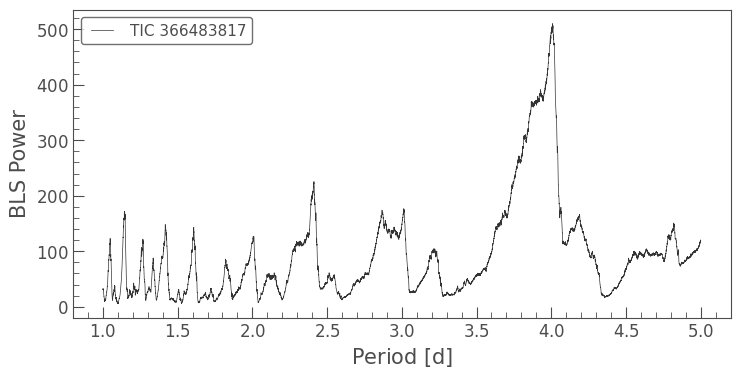

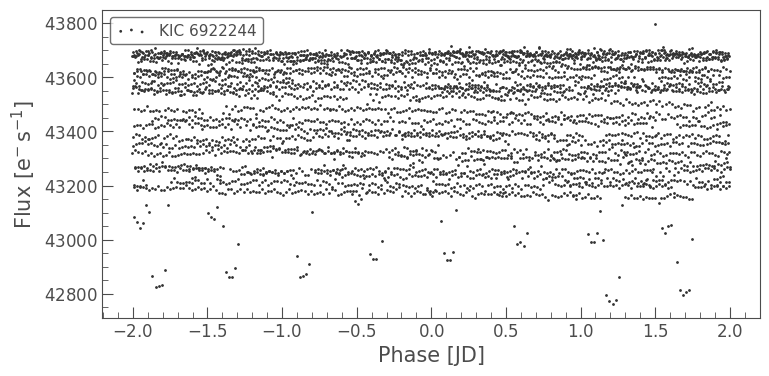

In [ ]:
# Repeating the same steps done for Kepler 8b, but this time on a different object.
tpf= TessTargetPixelFile('/content/TESS/MAST_2024-01-27T2308/TESS/tess2019006130736-s0007-0000000366483817-0131-s/tess2019006130736-s0007-0000000366483817-0131-s_tp.fits')
tpf.plot(frame=42)
tpf_lc=tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
tpf_lc.plot()
flat_tpf=tpf_lc.flatten()
flat_tpf.plot()
period=np.linspace(1,5,10000)
bls=tpf_lc.to_periodogram(method='bls',period=period,frequency_factor=500)
bls.plot()


planet_x_period=bls.period_at_max_power
planet_x_t=bls.transit_time_at_max_power
planet_x_dur=bls.duration_at_max_power
ax=lc.fold(period=planet_x_period,epoch_time=planet_x_t).scatter()
f'The period of the planet is {planet_x_period}'







Acknowledgements:

1) Jacob T. VanderPlas Understanding the Lomb-Scargle Periodogram, https://arxiv.org/pdf/1703.09824.pdf

2) Image from Wikipedia https://en.wikipedia.org/wiki/Methods_of_detecting_exoplanets#/media/File:Planetary_transit.svg

3)Vanderspek et al. (2019). “TESS Discovery of an Ultra-short-period Planet around the Nearby M Dwarf LHS 3844.”

4) The Barbara A. Mikulski Archive for Space Telescopes.




